# Evaluating the performance of the Phosphopedia retention time predictor on test data


In [1]:
try:
    from google.colab import drive
    drive.mount("data", force_remount=True)
    wd = "data/Shared drives/Villen_Lab/Anthony Valente/PhosphopediaNotebook/"

except Exception as e:
    print(e)
    wd = "./"

Mounted at data


In [2]:
import os
import json
import requests
import numpy as np
import pandas as pd
from uuid import uuid4

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import (
    backend, callbacks, models, layers,
    optimizers, regularizers, wrappers
)

## Intro

In the previous notebook, filtering was performed on the training set in order to remove problematic peptides. This filtering will not directly be performed here. Instead, we will evaluate the final model on all test peptides, and then show that by partitioning the test peptides by an independent variable, i.e. number of detections in the database, we can get a sense of how well the model would do on new data.

## Utility

#### Encoder

In [3]:
if not os.path.exists("sequence_encoder.py"): 
    url = "https://gist.githubusercontent.com/AnthonyOfSeattle/43b932bcb9b5b4b00ccbe96c29769db9/raw/a7a8bf8018a1e9a7b6900dfc61230718ea8843fb/sequence_encoder.py"
    r = requests.get(url)
    with open("sequence_encoder.py", "wb") as f:
        f.write(r.content)

from sequence_encoder import SequenceEncoder

GLOBAL_VOCAB = {
    "X": 0,
    "n[42]": 1,
    "A": 2,
    "C": 3,
    "C[57]": 3,
    "D": 4,
    "E": 5,
    "F": 6,
    "G": 7,
    "H": 8,
    "I": 9,
    "K": 10,
    "L": 11,
    "M": 12,
    "N": 13,
    "P": 14,
    "Q": 15,
    "R": 16,
    "S": 17,
    "T": 18,
    "U": 19,
    "V": 20,
    "W": 21,
    "Y": 22,
    "M[16]": 23,
    "S[80]": 24,
    "T[80]": 25,
    "Y[80]": 26
    }

#### Plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def plot_correlation(y, pred_y, count):
    y, pred_y, count = y.flatten(), pred_y.flatten(), count.flatten()
    
    fig = plt.figure(figsize=(7, 7))

    order = np.argsort(count)
    sns.scatterplot(x=y[order], 
                    y=pred_y[order],
                    hue=np.log10(count[order]),
                    linewidth=0,
                    alpha=.25,
                    s=10,
                    palette="inferno")
    
    # Grab correlations and insert into figure
    total_corr = np.corrcoef(y, pred_y)[0,1]
    plt.text(105, 5, s="Corr: %.3f" % total_corr, size = 28, ha="right")

    filtered_corr = np.corrcoef(y[count > 5], pred_y[count > 5])[0,1]
    plt.text(105, -5, s="Filtered Corr: %.3f" % filtered_corr, size = 28, ha="right")

    # Finish up design
    plt.xlim(-10, 110)
    plt.xticks(np.linspace(0, 100, num=6))
    plt.ylim(-10, 110)
    plt.yticks(np.linspace(0, 100, num=6))
    plt.legend(title='Log10 Examples', 
               bbox_to_anchor=(1.05, 1),
               loc='upper left',
               frameon=False,
               fontsize=28,
               title_fontsize=32)
    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)

    plt.xlabel("Predicted RT", size=32)
    plt.ylabel("Database RT", size=32)
    plt.tick_params(labelsize=32)

In [6]:
def error_by_count(y, pred_y, count):
    y, pred_y, count = y.flatten(), pred_y.flatten(), count.flatten()
        
    fig = plt.figure(figsize=[9, 5])

    abs_diff = np.abs(y - pred_y)
    plt.scatter(
        count,
        abs_diff,
        c="black", alpha=.3, s=5
    )

    plt.xlim(.9, 2500)
    plt.xscale("log")
    plt.xlabel("Number of hits for iRT estimation", size=32)
    plt.ylabel("Absolute\npredictive error", size=32)
    plt.tick_params(labelsize=32)

    fig.get_axes()[0].spines["right"].set_visible(False)
    fig.get_axes()[0].spines["top"].set_visible(False)

## Evaluation

From the last notebook, I have a single model which is labeled for the human phosphopedia. This is the model which is being exported for use in DeepPepServer and is thus also the model I will test here.

In [7]:
backend.clear_session()
model_config = open(wd + "/trained_models/update_20210902/export/human_phosphopedia_rt.config.json", "rb").read()
model = models.model_from_json(model_config)
model.load_weights(wd + "/trained_models/update_20210902/export/human_phosphopedia_rt.weights.h5")

In [8]:
test = pd.read_csv(wd + "data/modeling_splits/update_20210902/retention_time_test.csv")

encoder = SequenceEncoder(pattern="[A-Zn][^A-Zn]*",
                          vocab=GLOBAL_VOCAB,
                          seq_len=75)

test_X = encoder.transform(test.sequence)
test_y = test.learned_rt.values

pred_y = model.predict(test_X)

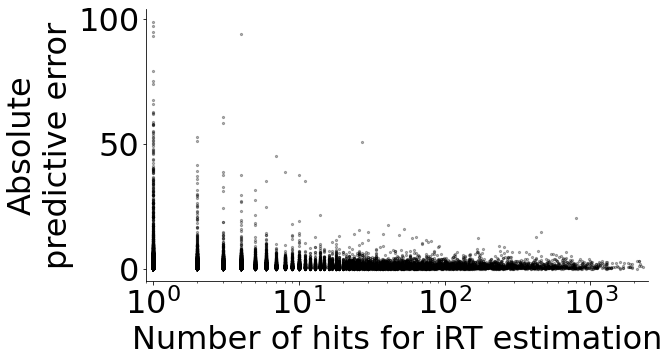

In [9]:
error_by_count(test_y[~test.learned_rt.isna()], 
               pred_y[~test.learned_rt.isna()],
               test.hits.values[~test.learned_rt.isna()])

plt.savefig(wd + "figures/rt_pred_error_by_hits.svg",
            bbox_inches="tight")
plt.show()

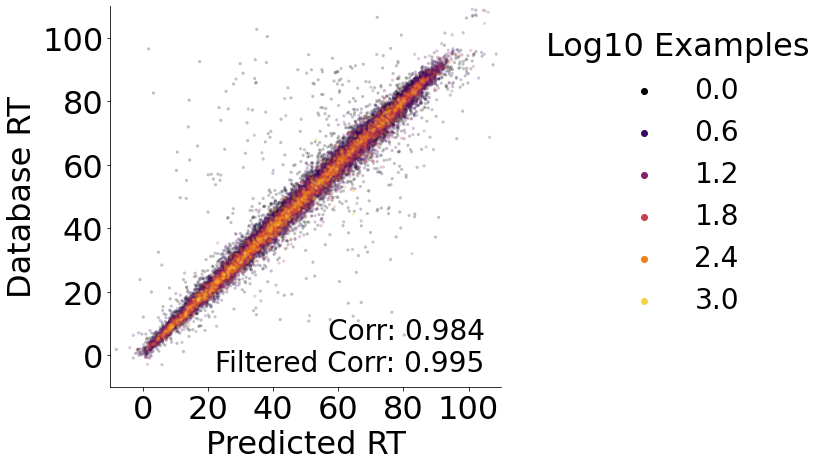

In [10]:
plot_correlation(test_y[~test.learned_rt.isna()], 
                 pred_y[~test.learned_rt.isna()],
                 test.hits.values[~test.learned_rt.isna()])
plt.savefig(wd + "figures/rt_pred_vs_real.svg",
            bbox_inches="tight")
plt.show()

The above graph beautifully demostrates the phenomena that the increased detections in the database leads to lower variance RT estimates. This is likely the performance we will get on new data. However, it should be noted that the next step is to actually test the performance on a novel dataset and show that we aren't actually biasing ourselves.